<a href="https://colab.research.google.com/github/Harshit0208/Movie-Recommendation-System-using-deep-learning/blob/master/recommendation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F 
from torch.optim.lr_scheduler import _LRScheduler

In [0]:
import math
from itertools import zip_longest

In [0]:
%matplotlib inline


In [0]:
plt.style.use('ggplot')

In [0]:
def set_random_seed(state=1):
    gens = (np.random.seed, torch.manual_seed, torch.cuda.manual_seed)
    for set_state in gens:
        set_state(state)

In [0]:

RANDOM_STATE = 1
set_random_seed(RANDOM_STATE)

In [0]:
ratings=pd.read_csv("/content/drive/My Drive/Colab Notebooks/ml-latest/ratings.csv")

In [13]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


In [0]:
movies=pd.read_csv("/content/drive/My Drive/Colab Notebooks/ml-latest/movies.csv")

In [15]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [0]:
"""Creates a cross-tabular view of users vs movies."""
def tabular_preview(ratings, n=15):
    
    
    user_groups = ratings.groupby('userId')['rating'].count()
    top_users = user_groups.sort_values(ascending=False)[:15]

    movie_groups = ratings.groupby('movieId')['rating'].count()
    top_movies = movie_groups.sort_values(ascending=False)[:15]

    top = (
        ratings.
        join(top_users, rsuffix='_r', how='inner', on='userId').
        join(top_movies, rsuffix='_r', how='inner', on='movieId'))

    return pd.crosstab(top.userId, top.movieId, top.rating, aggfunc=np.sum)

In [17]:
tabular_preview(ratings, movies)


movieId,1,110,260,296,318,356,480,527,589,593,1196,1198,1210,2571,2959
userId,,,,,,,,,,,,,,,
48470,4.5,4.5,4.0,5.0,4.5,4.0,4.0,4.5,5.0,3.5,4.0,3.0,3.5,3.5,3.5
63783,5.0,1.0,5.0,5.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,4.0,5.0,5.0,5.0
77609,3.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.5,2.5,4.0,3.0,4.0,2.0
94843,1.0,2.5,2.5,3.5,2.5,3.0,1.0,0.5,NaN,3.0,2.5,2.5,1.0,3.0,2.5
111908,5.0,3.5,5.0,5.0,5.0,2.0,3.0,5.0,4.0,2.0,5.0,5.0,3.5,5.0,4.0
117490,4.0,5.0,4.0,4.5,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0
123100,4.0,3.5,4.0,4.5,4.5,3.5,4.0,4.5,4.0,4.0,4.0,4.0,4.0,4.0,3.5
134596,3.0,4.0,4.0,4.0,4.5,3.0,4.0,4.0,4.0,4.0,4.0,4.5,4.0,4.5,4.0
141955,2.5,2.5,3.5,3.0,1.0,1.0,2.0,NaN,3.0,3.0,3.5,3.0,3.0,2.5,1.5


In [0]:
def create_dataset(ratings, top=None):
    if top is not None:
        ratings.groupby('userId')['rating'].count()
    
    unique_users = ratings.userId.unique()
    user_to_index = {old: new for new, old in enumerate(unique_users)}
    new_users = ratings.userId.map(user_to_index)
    
    unique_movies = ratings.movieId.unique()
    movie_to_index = {old: new for new, old in enumerate(unique_movies)}
    new_movies = ratings.movieId.map(movie_to_index)
    
    n_users = unique_users.shape[0]
    n_movies = unique_movies.shape[0]
    
    X = pd.DataFrame({'user_id': new_users, 'movie_id': new_movies})
    y = ratings['rating'].astype(np.float32)
    return (n_users, n_movies), (X, y), (user_to_index, movie_to_index)

In [21]:
(n, m), (X, y), _ = create_dataset(ratings)
print(f'Embeddings: {n} users, {m} movies')
print(f'Dataset shape: {X.shape}')
print(f'Target shape: {y.shape}')

Embeddings: 283228 users, 53889 movies
Dataset shape: (27753444, 2)
Target shape: (27753444,)


In [0]:
class ReviewsIterator:
    
    def __init__(self, X, y, batch_size=32, shuffle=True):
        X, y = np.asarray(X), np.asarray(y)
        
        if shuffle:
            index = np.random.permutation(X.shape[0])
            X, y = X[index], y[index]
            
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n_batches = int(math.ceil(X.shape[0] // batch_size))
        self._current = 0
        
    def __iter__(self):
        return self
    
    def __next__(self):
        return self.next()
    
    def next(self):
        if self._current >= self.n_batches:
            raise StopIteration()
        k = self._current
        self._current += 1
        bs = self.batch_size
        return self.X[k*bs:(k + 1)*bs], self.y[k*bs:(k + 1)*bs]

In [0]:
def batches(X, y, bs=32, shuffle=True):
    for xb, yb in ReviewsIterator(X, y, bs, shuffle):
        xb = torch.LongTensor(xb)
        yb = torch.FloatTensor(yb)
        
        yield xb, yb.view(-1, 1)

In [25]:
for x_batch, y_batch in batches(X, y, bs=8):
    print(x_batch)
    print(y_batch)
    break

tensor([[177611,   3259],
        [250359,   1088],
        [ 72238,   2614],
        [207758,   3429],
        [ 63362,    902],
        [137553,    521],
        [100447,   2586],
        [  8769,   2209]])
tensor([[2.],
        [3.],
        [3.],
        [3.],
        [3.],
        [3.],
        [3.],
        [4.]])


In [0]:
class EmbeddingNet(nn.Module):
    """
    Creates a dense network with embedding layers.
    
    Args:
    
        n_users:            
            Number of unique users in the dataset.

        n_movies: 
            Number of unique movies in the dataset.

        n_factors: 
            Number of columns in the embeddings matrix.

        embedding_dropout: 
            Dropout rate to apply right after embeddings layer.

        hidden:
            A single integer or a list of integers defining the number of 
            units in hidden layer(s).

        dropouts: 
            A single integer or a list of integers defining the dropout 
            layers rates applyied right after each of hidden layers.
            
    """
    def __init__(self, n_users, n_movies,
                 n_factors=50, embedding_dropout=0.02, 
                 hidden=10, dropouts=0.2):
        
        super().__init__()
        hidden = get_list(hidden)
        dropouts = get_list(dropouts)
        n_last = hidden[-1]
        
        def gen_layers(n_in):
            """
            A generator that yields a sequence of hidden layers and 
            their activations/dropouts.
            
            Note that the function captures `hidden` and `dropouts` 
            values from the outer scope.
            """
            nonlocal hidden, dropouts
            assert len(dropouts) <= len(hidden)
            
            for n_out, rate in zip_longest(hidden, dropouts):
                yield nn.Linear(n_in, n_out)
                yield nn.ReLU()
                if rate is not None and rate > 0.:
                    yield nn.Dropout(rate)
                n_in = n_out
            
        self.u = nn.Embedding(n_users, n_factors)
        self.m = nn.Embedding(n_movies, n_factors)
        self.drop = nn.Dropout(embedding_dropout)
        self.hidden = nn.Sequential(*list(gen_layers(n_factors * 2)))
        self.fc = nn.Linear(n_last, 1)
        self._init()
        
    def forward(self, users, movies, minmax=None):
        features = torch.cat([self.u(users), self.m(movies)], dim=1)
        x = self.drop(features)
        x = self.hidden(x)
        out = torch.sigmoid(self.fc(x))
        if minmax is not None:
            min_rating, max_rating = minmax
            out = out*(max_rating - min_rating + 1) + min_rating - 0.5
        return out
    
    def _init(self):
        """
        Setup embeddings and hidden layers with reasonable initial values.
        """
        
        def init(m):
            if type(m) == nn.Linear:
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)
                
        self.u.weight.data.uniform_(-0.05, 0.05)
        self.m.weight.data.uniform_(-0.05, 0.05)
        self.hidden.apply(init)
        init(self.fc)
    
    
def get_list(n):
    if isinstance(n, (int, float)):
        return [n]
    elif hasattr(n, '__iter__'):
        return list(n)
    raise TypeError('layers configuraiton should be a single number or a list of numbers')

In [27]:
EmbeddingNet(n, m, n_factors=150, hidden=100, dropouts=0.5)

EmbeddingNet(
  (u): Embedding(283228, 150)
  (m): Embedding(53889, 150)
  (drop): Dropout(p=0.02)
  (hidden): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5)
  )
  (fc): Linear(in_features=100, out_features=1, bias=True)
)

In [28]:
EmbeddingNet(n, m, n_factors=150, hidden=[100, 200, 300], dropouts=[0.25, 0.5])

EmbeddingNet(
  (u): Embedding(283228, 150)
  (m): Embedding(53889, 150)
  (drop): Dropout(p=0.02)
  (hidden): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25)
    (3): Linear(in_features=100, out_features=200, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5)
    (6): Linear(in_features=200, out_features=300, bias=True)
    (7): ReLU()
  )
  (fc): Linear(in_features=300, out_features=1, bias=True)
)

In [0]:
class CyclicLR(_LRScheduler):
    
    def __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]

In [0]:
def triangular(step_size, max_lr, method='triangular', gamma=0.99):
    
    def scheduler(epoch, base_lr):
        period = 2 * step_size
        cycle = math.floor(1 + epoch/period)
        x = abs(epoch/step_size - 2*cycle + 1)
        delta = (max_lr - base_lr)*max(0, (1 - x))

        if method == 'triangular':
            pass  # we've already done
        elif method == 'triangular2':
            delta /= float(2 ** (cycle - 1))
        elif method == 'exp_range':
            delta *= (gamma**epoch)
        else:
            raise ValueError('unexpected method: %s' % method)
            
        return base_lr + delta
        
    return scheduler

In [0]:

def cosine(t_max, eta_min=0):
    
    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1 + math.cos(math.pi*t/t_max))/2
    
    return scheduler

In [0]:
def plot_lr(schedule):
    ts = list(range(1000))
    y = [schedule(t, 0.001) for t in ts]
    plt.plot(ts, y)

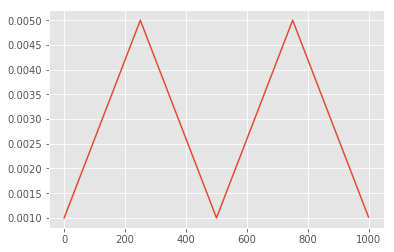

In [33]:
plot_lr(triangular(250, 0.005))

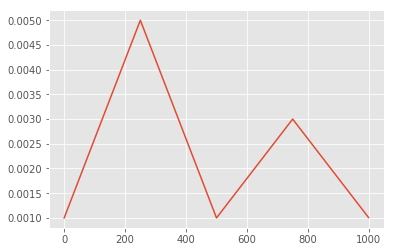

In [34]:
plot_lr(triangular(250, 0.005, 'triangular2'))

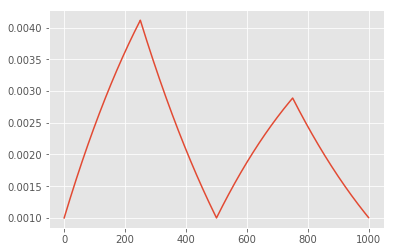

In [35]:
plot_lr(triangular(250, 0.005, 'exp_range', gamma=0.999))

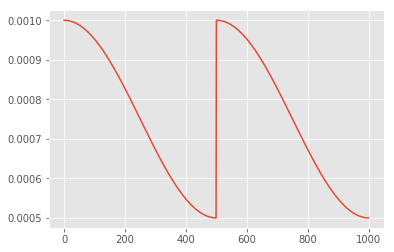

In [36]:
plot_lr(cosine(t_max=500, eta_min=0.0005))

In [0]:

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
datasets = {'train': (X_train, y_train), 'val': (X_valid, y_valid)}
dataset_sizes = {'train': len(X_train), 'val': len(X_valid)}

In [39]:
minmax = ratings.rating.min().astype(float), ratings.rating.max().astype(float)
minmax

(0.5, 5.0)

In [0]:

net = EmbeddingNet(
    n_users=n, n_movies=m, 
    n_factors=150, hidden=[500, 500, 500], 
    embedding_dropout=0.05, dropouts=[0.5, 0.5, 0.25])

In [41]:
lr = 1e-3
wd = 1e-5
bs = 2000
n_epochs = 100
patience = 10
no_improvements = 0
best_loss = np.inf
best_weights = None
history = []
lr_history = []

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net.to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
iterations_per_epoch = int(math.ceil(dataset_sizes['train'] // bs))
scheduler = CyclicLR(optimizer, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/10))

for epoch in range(n_epochs):
    stats = {'epoch': epoch + 1, 'total': n_epochs}
    
    for phase in ('train', 'val'):
        training = phase == 'train'
        running_loss = 0.0
        n_batches = 0
        
        for batch in batches(*datasets[phase], shuffle=training, bs=bs):
            x_batch, y_batch = [b.to(device) for b in batch]
            optimizer.zero_grad()
        
            # compute gradients only during 'train' phase
            with torch.set_grad_enabled(training):
                outputs = net(x_batch[:, 1], x_batch[:, 0], minmax)
                loss = criterion(outputs, y_batch)
                
                # don't update weights and rates when in 'val' phase
                if training:
                    scheduler.step()
                    loss.backward()
                    optimizer.step()
                    lr_history.extend(scheduler.get_lr())
                    
            running_loss += loss.item()
            
        epoch_loss = running_loss / dataset_sizes[phase]
        stats[phase] = epoch_loss
        
        # early stopping: save weights of the best model so far
        if phase == 'val':
            if epoch_loss < best_loss:
                print('loss improvement on epoch: %d' % (epoch + 1))
                best_loss = epoch_loss
                best_weights = copy.deepcopy(net.state_dict())
                no_improvements = 0
            else:
                no_improvements += 1
                
    history.append(stats)
    print('[{epoch:03d}/{total:03d}] train: {train:.4f} - val: {val:.4f}'.format(**stats))
    if no_improvements >= patience:
        print('early stopping after epoch {epoch:03d}'.format(**stats))
        break

RuntimeError: ignored

In [42]:
ax = pd.DataFrame(history).drop(columns='total').plot(x='epoch')

KeyError: ignored

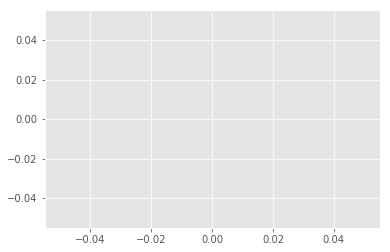

In [43]:
_ = plt.plot(lr_history[:2*iterations_per_epoch])

In [44]:
net.load_state_dict(best_weights)


AttributeError: ignored

In [45]:
groud_truth, predictions = [], []

with torch.no_grad():
    for batch in batches(*datasets['val'], shuffle=False, bs=bs):
        x_batch, y_batch = [b.to(device) for b in batch]
        outputs = net(x_batch[:, 1], x_batch[:, 0], minmax)
        groud_truth.extend(y_batch.tolist())
        predictions.extend(outputs.tolist())

groud_truth = np.asarray(groud_truth).ravel()
predictions = np.asarray(predictions).ravel()

RuntimeError: ignored

In [46]:

final_loss = np.sqrt(np.mean((predictions - groud_truth)**2))
print(f'Final RMSE: {final_loss:.4f}')

TypeError: ignored